# Binary Image Classification

## **Exploring the dataset**

We'll use the dataset provided in the Histopathologic Cancer Detection competition on Kaggle. The goal of this competition is to classify image patches as normal or malignant. In this section, we will investigate the dataset.

### **Getting ready**

Dataset url : [histopathologic cancer data](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

Inside the `data` folder, there are two folders: `train` and `test`. The `train` folder contains $220,025$ `.tif` images that are $96 \times 96$ in size. The `.tif` images are named with an image ID. The `train_labels.csv` file provides the ground truth for the images in the `train` folder.

There are no labels for the test images. If we were to compete in the competition, we would need to provide predictions on the test dataset and submit them to the competition for evaluation.

### **How to do it**

To learn about the dataset, we'll start by loading the labels and displaying a few sample images from the dataset:

In [1]:
# 1 Let's begin by reading train_labels.csv and prining out its head
import pandas as pd

path2csv = "../data/histopathologic-cancer-detection/train_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [2]:
# 2 Let's count the number of normal and malignant cases
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


<AxesSubplot:>

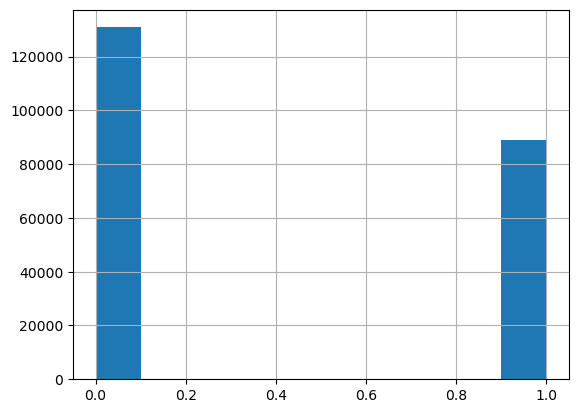

In [3]:
# 3 Let's look at a histogram of the lables
%matplotlib inline
labels_df['label'].hist()

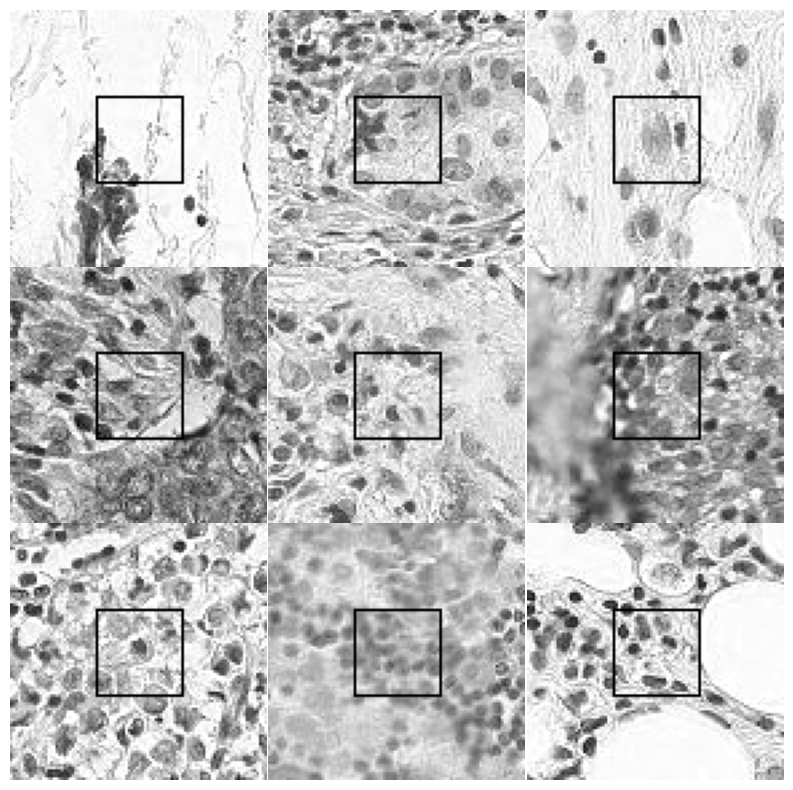

In [4]:
# 4 Let's visualize a few images that have a positive label. A positive label shows that
# the center 32 x 32 region of an image contains at least one pixel of
# tumor tissue. First, we import the required packages:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline
# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

# Define the path to data:
# data is stored here
path2train = "../data/histopathologic-cancer-detection/train/"

# Next, we define a flag to show images in grayscale or color mode:
# show images in grayscale, if you want color change it to True
color=False

# Next, we set the figure sizes:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols=3,3

# Next, we display the images:
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)), outline="green")
    plt.subplot(nrows, ncols, i+1) 
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:, : ,0], cmap="gray")
    plt.axis('off')

In [5]:
# 5 Let's also get the image's shape and minimum and maximum pixel values:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


### **How it works**

First, we loaded the labels as a DataFrame using `pandas`. The DataFrame has two columns: **id** and **label**. The **id** column refers to the image filename, while the **label** column shows whether the image is **normal (label=$0$)** or **malignant (label=$1$)**.

In step 2, we counted the number of normal and malignant images. As we saw, around $59\%$ of the images were normal and $41\%$ were malignant. The histogram in step 3 shows somewhat imbalanced data.

Then, we displayed a few sample images. Please note that we show the images in grayscale mode as they might be unpleasant in color.

As we saw, the images are colored images with three channels $(96, 96, 3)$. The pixel values are in the range $[0, 255]$.

It is really difficult to tell whether an image is malignant just by looking at it. So, you can imagine why it's a difficult task for clinicians to inspect so many images every day. Hopefully, we can develop an automated tool to help them in their routine tasks.

## **Creating a custom dataset**

A traditional method for working with a dataset would be to load all images into NumPy arrays. Since we are dealing with a relatively large dataset, this would be a waste of our computer resources. If you are short on RAM, this would be impossible. Luckily, PyTorch has a powerful tool to handle large datasets.

**We can create a custom Dataset class by subclassing the PyTorch `Dataset` class**. When creating a custom Dataset class, make sure to define two essential functions: `__len__` and `__getitem__`. The `__len__` function returns the dataset's length. This function is callable with the Python len function. The `__getitem__` function returns an image at the specified index.

### **How to do it**

We will define a class for the custom dataset, define the transformation function, and then load an image from the dataset using the `Dataset` class. Let's get started:

In [6]:
# 1 Let's create a PyTorch custom dataset for our data
# first we will load the required packages
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# Don't forget to fix the random seed for reproductibility
torch.manual_seed(0)

# Define the histoCancerDataset class
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path to images
        path2data = os.path.join(data_dir, data_type)

        # get a list of images
        self.filenames = os.listdir(path2data)

        # get the full paht to images
        self.full_filenames = [os.path.join(path2data, f) for f in self.filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename = data_type + "_labels.csv"
        path2csvLabels=os.path.join(data_dir, csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in self.filenames]

        self.transform = transform
    
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)


    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [7]:
# 2 Next. we will define a simple transformation that only converts a PIL image into Pytorch tensors.
# Later, we will expand this
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

# 3 Then, we will define an object of the custom dataset forthe train folder
data_dir = "../data/histopathologic-cancer-detection/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

# 4 Next, we will load an image using the custom dataset
# load an image
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

220025
torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


### **How it works**

In step 1, we imported the required packages. The `PIL` package is imported to load images. From `torch.utils.data`, we import `Dataset` as the base class of our custom dataset. The `pandas` package is imported to load the CSV files. We also used `torchvision` for data transformation.

Then, we defined the `Dataset` class. In the `__init__` function, we received the path to the data and the `data_type`. The `data_type` can be either *train* or *test*. The class, like any PyTorch dataset, has the `__len__` and `__getitem__` functions. The `__len__` function returns the length of the dataset. The `__getitem__` function also returns the transformed image at the given index and its corresponding label.

In step 2, we defined the transformation function. For now, we only convert `PIL` images into Pytorch tensors in the transformation function.

In step 3, as expected, the length of `histo_dataset` is $220025$.

In step 4, we can see that the dataset returns images in the (Channels, Height, Width) format and pixel values are normalized to the range $[0.0, 1.0]$. This is the result of transforms. `ToTensor()` converts a `PIL` image into the range $[0, 255]$ to `torch.FloatTensor` of shape `(C x H x W)` in the range $[0.0, 1.0]$. It is common to use this formatting when working with images in PyTorch.

## **Splitting the dataset**

We need to provide a validation dataset to track the model's performance during training. We use $20\%$ of `histo_dataset` as the validation dataset and use the rest as the training dataset.

### **How to do it**

We will split the dataset into training and validation and then display a few sample images from each dataset. Let's get started:

In [8]:
# 1 Let's split histo_dataset
from torch.utils.data import random_split
len_histo = len(histo_dataset)
len_train = int(.8 * len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])
print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [9]:
# 2 Then, we can get an image from the training dataset:
for x, y in train_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 1


In [10]:
# 3 We will also get an image from the validation dataset:
for x,y in val_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 1


Image indices :  [ 43567 173685 117952 152315]


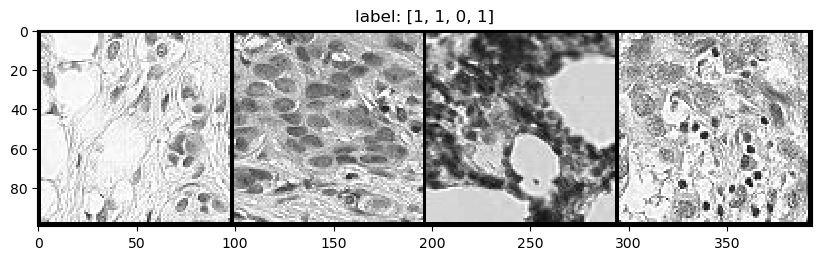

In [11]:
# 4 Let's display a few samples from train_ds.
# Import the required packages:

from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

# Define a helper function to show an image:
def show(img, y, color=False):
    # convert tensor to numpy array
    npimg = img.numpy()

    # convert to H x W x C shape
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    if color==False:
        npimg_tr=npimg_tr[:, :, 0]
        plt.imshow(npimg_tr, interpolation='nearest', cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr, interpolation='nearest')
    plt.title("label: " + str(y))

# Create a grid of sample images
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print("Image indices : ", rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=4, padding=2)

# Call the helper function to display the grid
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train)

image indices :  [30403 32103 41993 20757]
torch.Size([3, 100, 394])


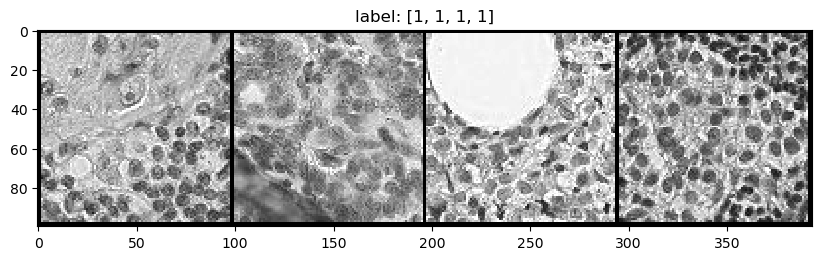

In [12]:
# 5 We can also show a few smaples from val_ds
grid_size = 4
rnd_inds = np.random.randint(0,len(val_ds),grid_size)
print("image indices : ",rnd_inds)
x_grid_val = [val_ds[i][0] for i in range(grid_size)]
y_grid_val = [val_ds[i][1] for i in range(grid_size)]

x_grid_val = utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)
show(x_grid_val, y_grid_val)

### **How it works**

In step 1, we used the `random_split` function from `torch.utils.data` to split the dataset. This will return two datasets: `train_ds` and `val_ds` with lengths of $176020$ and $44005$, respectively.

In steps 2 and 3, we get an image and its label from each dataset. The image shape was in the format (`C x H x W`), as expected.

In steps 4 and 5, we displayed sample images from `train_ds` and `val_ds`.

## **Transforming the data**

**Image transformation and image augmentation are necessary for training deep learning models**. By **using image transformations**, we can **expand our dataset or resize and normalize it to achieve better model performance**. Typical transformations include **horizontal and vertical flipping**, **rotation**, and **resizing**. The good news is that we can use various image transformations for our binary classification model without making label changes. For instance, if we rotate or flip a malignant image, it will remain malignant. In this recipe, you will learn how to use the `torchvision` package to perform on-the-fly image transformation during training.

### **How to do it**

We will define a few image transformations and then update the dataset transformation function. Let's get started:

In [13]:
# 1 First, let's define the following transformations for the training dataset:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(96, scale=(0.8,1.0), ratio=(1.0,1.0)),
    transforms.ToTensor()]
)      

# 2 For the validation dataset, we don't need any augmentation. So, we only convert the images into tensors in the transforms function:
val_transformer = transforms.Compose([transforms.ToTensor()])

# 3 After defining the transformations, we overwrite the transform functions of train_ds and val_ds:
# overwrite the transform functions
train_ds.transform = train_transformer
val_ds.transform = val_transformer

### **How it works**

In step 1, `RandomHorizontalFlip` and `RandomVerticalFlip` will flip the image horizontally and vertically with a probability of $0.5$, respectively. The RandomRotation function rotates images in the range of $[-45,45]$ degrees. Also, `RandomSizedCrop` crops a square image randomly in the range of $[72, 96]$ and then resizes it to the original size of $96 \times 96$.

In step 2, we used `transforms.ToTensor` to normalize the images in the range $[0, 1]$ and convert them into tensors. It is common to normalize images to zero-mean and unit-variance by subtracting the mean and diving into the standard deviation of the pixel values. However, here, we opt not to do any further normalization.

The validation dataset was only normalized to the range $[0, 1]$ without any data augmentation.

Finally, in step 3, we defined the transformations and overwrote the transform functions of `train_ds` and `val_ds`.

## **Creating dataloaders**

We are ready to create a PyTorch dataloader. **If we do not use dataloaders, we have to write code to loop over datasets and extract a data batch**. This process can be **made automatically** using a PyTorch `Dataloader`.

### **How to do it**

we will define two dataloaders and then show you how to get a batch of data using the dataloaders. Let's get started:

In [32]:
# 1 First, let's define two dataloaders for the datasets:
from torch.utils.data import DataLoader
# train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
# val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)


# 2 Then, we get a data batch from the training dataloader:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break
torch.Size([32, 3, 96, 96])
torch.Size([32])

# 3 Next, we get a data batch from the validation dataloader:
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])
torch.Size([32, 3, 96, 96])
torch.Size([32])


### **How it works**

In step 1, when defining a PyTorch Dataloader, we need to define the batch size. The batch size determines the number of images to be extracted from the dataset in each iteration. The typical values of the batch size for classification tasks are in the range of $[8-128]$. Also, note that we do not need to shuffle the validation data during evaluation.

> If your computer or the GPU device on your computer does not have enough memory, you can reduce the batch size to avoid memory errors.

When iterating over a dataloader, it will automatically extract batches of data from the dataset. As seen in step 2, for the train dataloader, we extracted batches of images that were $32$ in size. This was $64$ for the validation dataloader since we set the batch size to $64$.

## **Building the classification model**

In this section, we will build a model for our binary classification task. Our model is comprised of four **convolutional neural networks (CNNs)** and $2$ fully connected layers, as shown in the following diagram:

![](model_desc.png)

As we can see, there are $4$ **convolutional layers** and $2$ **fully connected layers** in the model. **After each convolutional layer, there is a pooling layer**. The pooling layers are not shown in the preceding diagram. **The convolutional layers process the input image and extract a feature vector, which is fed to the fully connected layers. There is an output layer for the binary classification**.

### **How to do it**

In [33]:
# 1 First, let's create dumb baselines for the validation dataset.
# get labels for validation dataset
y_val = [y for _, y in val_ds]

# Next, we will define a function to calculate the classification accuracy:
def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

In [34]:
# Then, we will calculate a dumb baseline for all-zero predictions
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("Accuracy all zero prediction : %.2f" % acc_all_zeros)

Accuracy all zero prediction : 0.59


In [35]:
# Next, we will calculate a dumb baseline for all-one predictions:
# accuracy all ones predictions
acc_all_ones = accuracy(y_val, np.ones_like(y_val))
print("Accuracy all one prediction : %.2f" % acc_all_ones)

Accuracy all one prediction : 0.41


In [36]:
# Next, we will calculate a dumb baseline for random predictions:
# accuracy random predictions
acc_random = accuracy(y_val, np.random.randint(2, size=len(y_val)))
print("Accuracy random prediction : %.2f" % acc_random)

Accuracy random prediction : 0.50


In [37]:
# 2 Let's implement a helper function to calculate the output size of a CNN layer.
# We will use the following packages
import torch.nn as nn
import numpy as np

# Then, we'll define the helper function
def findConv2dOutShape(H_in, W_in, conv, pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out = np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out = np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)

# Next, we will look at the helper function using an example:

# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [38]:
# 3 Next, we will implement the CNN model
# import the required packages
import torch.nn as nn
import torch.nn.functional as F

# Define the Net class
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()

        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h, w = findConv2dOutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)

        # compute the flatten size
        self.num_flatten = h * w * 8 * init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [39]:
# 4 Then, we will construct an object of the Net class:
# dict to define model parameters
params_model = {
        "input_shape": (3, 96, 96),
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2,
    }

# create model
cnn_model = Net(params_model)

In [40]:
# 5 Move the model to a cuda device if one's available
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model = cnn_model.to(device)

# 6 Print the model
print(cnn_model)

# 7 Verify the model device:
print(next(cnn_model.parameters()).device)

# 8 Let's get a summary of the model:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96), device=device.type)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)
cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
-------------------------------------

### **How it works**

In step 1, we created dumb baselines. **We should always establish a baseline before moving forward with complex models**. This will help us **find out how well we are performing**. We can create dumb baselines by **creating random predictions, all-zero predictions, or all-one predictions**. Let's create simple baselines using these predictions. It is interesting to see that we can get an accuracy of $0.60$ with dumb predictions.

In step 2, we developed `findConv2DOutShape` to **automatically compute the output size of a CNN and pooling layer**. The inputs to this function are:

* `H_in`: an **integer** representing the **height of input data**
* `W_in`: an **integer** representing the **width of input data**
* `conv`: an **object** of the **CNN layer**
* `pool`: an **integer** representing the **pooling size** and default to $2$

The function receives the input size, `H_in`, `W_in`, and  `conv` layer and provides the output size, `H_out`, `W_out`. The formula to compute the output size is given in the following link: https://pytorch.org/docs/stable/nn.html

In step 3, we implemented the CNN model using the `nn.Module` class. In the `__init__` function, we **define the layers of the model**. We **provide the model parameters as a Python dictionary to this function**. We **recommend using variables for the model parameters and a dictionary to define them outside the class**. This way, **in the case of parameter changes, we do not have to make changes inside the Net class**. This will also **make future hyperparameter searches easier**.

In the `forward` function, we use the defined layers to outline the model. We use `nn.Conv2d` and `nn.Linear` to define the CNN and fully connected layers, respectively. The **pooling layers, activations, and dropout layers act like functions** and can be defined using `nn.functional`. W**e do not need to define these layers in the** `__init__` function.

Each layer needs specific arguments to be defined.

For most layers, it is **important to specify the number of inputs and outputs of the layer**. For instance, the **first CNN layer** has `C_in=3` channels as **input** and` init_f=8` filters as **output**, as defined in the following code:
```python
self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
```

Similarly, the **second CNN layer** receives `init_f=8` channels as **input** and `2*init_f=16` channels as **output**. Thus, by providing the number of output channels of the previous layer as the number of input channels to the next layer, we can define each layer. However, this becomes tricky when it comes to nn.Linear layers. The linear layer accepts a 2D tensor. That is why we need the view method in the forward function to reshape the 4D tensor into a 2D tensor:

```python
x = x.view(-1, self.num_flatten) # flatten/reshape
```

How do we get the value of `self.num_flatten`? Well, PyTorch does not automatically calculate this value. It is our duty to find this value and provide it to the linear layer. One approach would be to print (`x.size()`) to get the output shape of each layer.

The other option is using the `findConv2DOutShape` function. The output size of the fourth CNN layer (together with the pooling layer) is h,w and there are `8*init_f` output channels. Therefore, after flattening, we get `self.num_flatten=h*w*8*init_f`.

We also added a dropout layer before the output layer to reduce the overfitting problem in deep learning models. Notice that we set the `training = self.training` argument in the `F.dropout` function. The `self.training` parameter is automatically set to `True` during training and `False` at evaluation. This will bypass the dropout layer at the deployment time.

> The dropout layer is only applied during training. At deployment, the dropout layer should be deactivated. To do so, make sure to set training argument of the dropout layer to False at deployment.

The last layer is `F.log_softmax(x, dim=1)` (with two outputs), which is equivalent to $log(softmax(x))$. We will explain why we choose this output in the next section when defining the loss function. Keep in mind that if we want to get the output probability value, we need to use the exponential operation.

In step 4, we constructed an object of the `Net` class. The input shape is the shape of the image tensors $(3,96,96)$. We choose `initial_filters=8` filters for the first CNN layer. The number of filters is automatically doubled in the next layers. Also, there are `num_fc1=100` units in the fully connected layer.

In step 5, if you have a CUDA device, always move the model to the CUDA device to take advantage of the computation acceleration.

> Always use `torch.cuda.is_available()` to avoid getting error in case your computer does not have a CUDA/GPU device.

In step 6, we verify that the model was moved to the CUDA device.

In step 7 and step 8, we printed the mode and also got the model summary. 

Then, we showed the model summary. The summary shows the output shape and the number of parameters per layer. However, this does not include the functional layers. **It is interesting to see that the fully connected layer has the highest number of parameters** ($102500$), **which is not efficient**. Therefore, **state-of-the-art deep learning models eliminate fully connected layers in their design**.

## **Defining the loss function**

The standard loss function for classification tasks is `cross-entropy loss` or `logloss`. However, when defining the loss function, **we need to consider the number of model outputs and their activation functions**. For binary classification tasks, we can choose one or two outputs.

The following table shows the corresponding loss functions for different activation functions:

| Output Activation | Number of Outputs | Loss Function          |
| ----------------- | ----------------- | ---------------------- |
| None              | $1$               | `nn.BCEWithLogitsLoss` |
| Sigmoid           | $1$               | `nn.BCELoss`           |
| None              | $2$               | `nn.CrossEntropyLoss`  |
| `log_softmax`     | $2$               | `nn.NLLLoss`           |


We recommend using the `log_softmax` function as **it is easier to expand to multi-class classification**. PyTorch combines the log and softmax operations into one function due to numerical stability and speed.

### **How to do it**

we will define the loss function and show you how to use it. Let's get started:

In [41]:
# 1 First, let's define the loss function, as follows
loss_func = nn.NLLLoss(reduction="sum")

# 2 Next, we will use the loss in an example
# fix random seed
torch.manual_seed(0)

n, c = 8, 2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out = ls_F(y)
print(y_out.shape)

target = torch.randint(c, size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [42]:
# 3 Then, we will compute the gradients of the loss with respect to `y`:
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


### **How it workds**

We use `log_softmax` as the output and `nn.NLLLoss` as the negative log-likelihood loss. An important argument in defining the loss function to pay attention to is the reduction, which specifies the reduction to apply to the output. There are three options to choose from: none, sum, and mean. We choose `reduction=sum` so that the output loss will be summed. Since we will process the data in batches, this will return the sum of loss values per batch of data.

In step 2, we calculate the loss using an example with `n=8` samples and `c=2` classes.

In step 3, we compute the gradients for the example in step 2. Later, we will use the backward method to compute the gradients of the loss with respect to the model parameters.

## **Defining the optimizer**

The `torch.optim` package provides the implementation of common optimizers. The optimizer will hold the current state and will update the parameters based on the computed gradients. For binary classification tasks, **SGD** and Adam optimizers are used the most.

Another helpful tool in the `torch.optim` package is **learning schedules**. **Learning schedules are useful tools for automatically adjusting the learning rate during training to improve model performance**. 

### **How to do it**

we'll learn how to define an optimizer, get the current learning rate, and define a learning scheduler. Let's get started:

In [43]:
# 1 First, let's define an object of the Adam optimizer with a learning rate of 3e-4:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

# 2 We can read the current value of the learning rate using the following function:
# get learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [44]:
# 3 Next, we will define a learning scheduler using the ReduceLROnPlateau method:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

# 4 Then, we will learn how the learning rate schedule works using the following example:
for i in range(100):
    lr_scheduler.step(1)

Epoch 00022: reducing learning rate of group 0 to 1.5000e-04.
Epoch 00043: reducing learning rate of group 0 to 7.5000e-05.
Epoch 00064: reducing learning rate of group 0 to 3.7500e-05.
Epoch 00085: reducing learning rate of group 0 to 1.8750e-05.


### **How it works**

In step 1, we defined the Adam optimizer. The **important parameters of the optimizer class are the model's parameters and the learning rate**. `cnn_model.parameters()` returns an iterator over module parameters that are passed to the optimizer. **The learning rate will determine the amount to update by**. In PyTorch, **we can set a different learning rate per layer**, but in this chapter, we'll choose to set one learning rate for all the layers.

In step 2, we developed a helper function that returns the current value of the learning rate.

In step 3, we used the `ReduceLROnPlateau` method from the `torch.optim.lr_scheduler` package. **This scheduler reads a metric quantity and if no improvement is seen for a patience number of epochs, the learning rate is reduced by a factor of $0.5$**. The `mode` argument defines **whether the metric quantity is increasing or decreasing during training**. For instance, if we monitor the loss value, we set `mode='min'`. If we monitor the accuracy, we should set `mode='max'`. 

In step 4, we showed you how the learning rate schedule works by passing it a constant value during a loop. As we saw, after every $20$ iterations, the scheduler reduces the learning rate by half.

## **Training and evaluation of the model**

So far, we've created the datasets, built the model, and defined the loss function and optimizer. In this recipe, we'll implement the training and validation scripts. T**he training and validation scripts can be long and repetitive**. For better code readability and to avoid code repetition, we'll build a few helper functions first.

### **How to do it**

we will show you how to train and evaluate the model using the training and validation dataset. Let's get started:

In [46]:
# 1 First, let's develop a helper function to count
# the number of correct predictions per data batch:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# 2 Then, we will develop a helper function to compute
# the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

# 3 Next, we develop a helper function to compute the
# loss value and the performance metric for the entire dataset, also called an epoch.
# Define the loss_epoch function
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # The function continues with an internal loop over the dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb = xb.to(device)
        yb = yb.to(device)
        # get model output
        output = model(xb)
        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        # update running loss
        running_loss += loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric += metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    # average loss value
    loss = running_loss/float(len_data)

    # average metric value
    metric = running_metric/float(len_data)
    return loss, metric

# 4 Let's develop the train_val function in the following code blocks
# Let's develop the train_val function in the following code blocks

# The function is too long, so we will present it in a few steps.
# Keep in mind that all the following code blocks belong to one function. 

# First, we extract the model parameters:
import copy
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    # Then, we define two dictionaries to keep a history of the loss and accuracy values:
    # history of loss values in each epoch
    loss_history = {
        "train": [],
        "val": [],
    }
    
    # history of metric values in each epoch
    metric_history = {
        "train": [],
        "val": [],
    }

    # Next, we will create a copy of state_dict:
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())

    # Then, we will initialize the best loss to an infinite value:
    # initialize best loss to a large value
    best_loss = float('inf')

    # Next, we will define a loop that will calculate the training loss over an epoch:
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func, train_dl, sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # Then, we will evaluate the model on the validation dataset:
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # Next, we will store the best weights:
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            # Then, we will update the learning rate if needed:
            # learning rate schedule
            lr_scheduler.step(val_loss)
            if current_lr != get_lr(opt):
                print("Loading best model weights!")
                model.load_state_dict(best_model_wts)

            # Finally, we will print the loss and accuracy values and return the trained model:
            print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss, 100*val_metric))
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts) 
    return model, loss_history, metric_history

In [48]:
# 5 Let's set the sanity_check flag to True and run the code
# Define the objects for the optimization, loss, and learning rate schedule
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

# Define the training parameters and call the train_val helper function:
params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "../models/weights.pt",
}

# train and validate the model
cnn_model, loss_hist, metric_hist = train_val(cnn_model, params_train)

Epoch 0/99, current lr=0.0003


KeyboardInterrupt: 

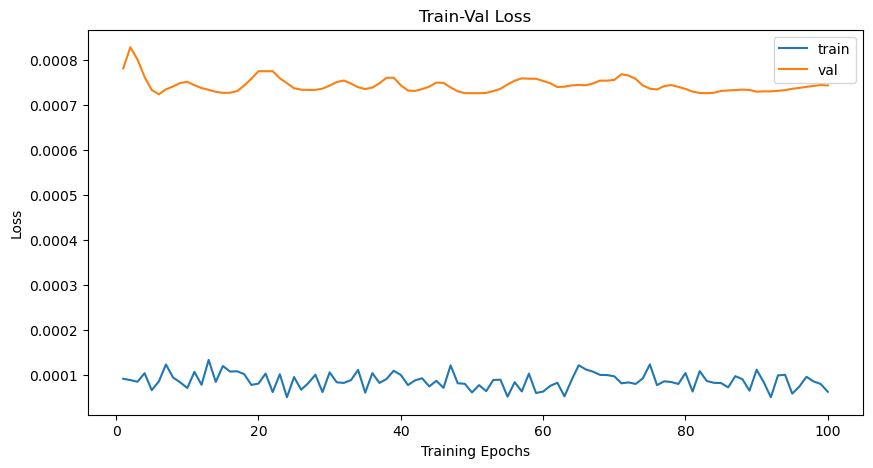

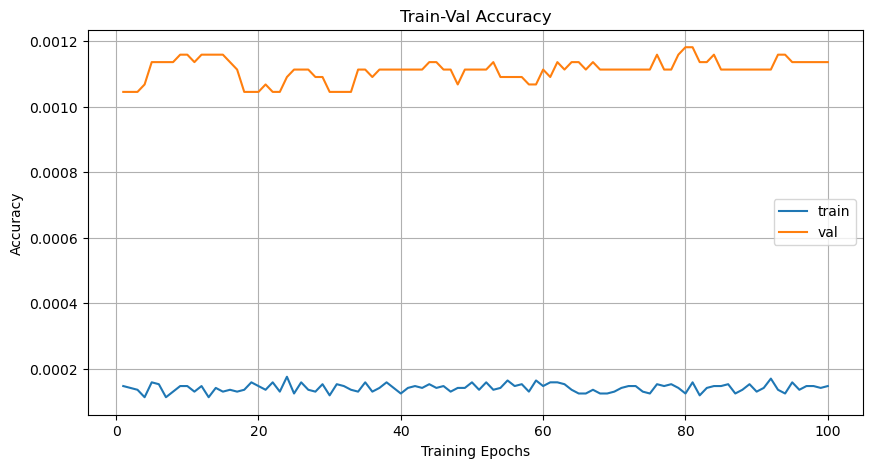

In [ ]:
# 6 Let's plot the training validation's progress using the returned values,
# that is, loss_hist and metric_hist:
# Train-Validation Progress
num_epochs = params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 7 By doing this, we've made sure that all the elements are implemented correctly.
# Let's set the flag to sanity_check: False and run the code.
# The training will start and we will see its progress, as shown in the following code block:

### **How it works**

In step 1, we counted the number of correct predictions per batch to be used for calculating the model accuracy.

In step 2, the `loss_batch` function receives the objects of the loss function and optimizer, the model output, and the ground truth label. We only perform the backpropagation step during training.

In step 3, the `loss_epoch` function receives the objects of the model, the loss function, a Dataloader, and the optimizer. We used the Dataloader to fetch batches of data from the dataset. Then, we moved the batch to the CUDA device and got the model's output. We also declared two variables to keep the loss and number of correct predictions after a batch is executed. You can see how the choice of `reduction="sum"` in the definition of the loss function is deployed to accumulate the loss over the entire dataset. The `sanity_check` flag breaks the loop to quickly execute the function in the case of debugging.

In step 4, we passed the parameters as a Python dictionary. This will improve the code's readability. We defined two dictionaries to record the loss and metric values during training for visualization purposes.

An important step is to track the model's performance during training to avoid overfitting. To this end, we evaluate the model on the validation dataset after each training epoch. Then, we compared the validation loss with the best validation loss, `val_loss < best_loss`. If the validation loss has improved, we store and make copies of the weights as the best model weights.

The learning rate scheduler monitors the validation loss and reduces the learning rate by a factor of two:
```python
lr_scheduler.step(val_loss) # learning rate schedule
```

Also, every time the learning rate is reduced, we would like to continue training from the best weights:
```python
if current_lr != get_lr(opt):
    print("Loading best model weights!")
    model.load_state_dict(best_model_wts)
```

**Developing and training deep learning models is time-consuming. The last thing you want is an error popping up somewhere in the middle of training. We recommend performing a sanity check before starting the actual training**. We created a flag called `sanity_check` for this purpose. If set to `True`, the training loop breaks after one batch in an epoch. Therefore, we get to see the whole loop in a short amount of time.

In step 5, the sanity check should quickly train and evaluate the model for $100$ epochs. Everything looks normal. Even the learning rate schedule was activated and reduced the learning rate from $3e^{-4}$ to $7.5e^{-5}$. The training loss converges to near zero, which makes it clear that we can overfit to one batch. Don't worry about accuracy. This is a sanity check, after all.

In step 6, we saw that, at some point, the learning rate schedule will reduce the learning rate after the validation loss does not improve for $20$ epochs. When this happens, the model is reloaded with the last best weights. That is why we see sudden jumps in the loss and accuracy curves at these points.

We stored the best model weights (`state_dict`) during training by tracking the model's performance on the validation dataset. The weights are located in the `../models/weights.pt` path. This is useful in case the program is stopped for any reason – at least you have a copy of the best weights.

### **There's more**

Once you get a baseline performance using your first model, you can start tuning hyperparameters. Hyperparameter tuning is a technique that's used to improve model performance. An effective way of doing this is by using a random search. We defined the hyperparameters as variables so that you can easily play with them. Try different values for the hyperparameters and see how the model's performance is affected. As an example, try increasing the number of CNN filters by setting `initial_filters = 16` and retraining the model.

## **Deploying the model**

We assume that you want to deploy the model for inference in a new script that's separate from the training scripts. In this case, the model and weights do not exist in memory. Therefore, we need to construct an object of the model class and load the weights into the model.

In [ ]:
# 1 First, we'll create an object of the Net class and load the stored weights into the model:
# model parameters
params_model = {
    "input_shape": (3, 96, 96),
    "initial_filters": 8, 
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2,
}

# initialize model
cnn_model = Net(params_model)

# 2 Let's load state_dict into the model:
# load state_dict into model

path2weights="../models/weights.pt"
cnn_model.load_state_dict(torch.load(path2weights))

# 3 Set the model in eval mode:
# set model in evaluation mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
# 4 Move the model onto a CUDA device if one's available:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model = cnn_model.to(device)

# 5 Let's develop a helper function to deploy the model on a dataset.
# Define the deploy_model function:
import time
def deploy_model(model,dataset, device, num_classes=2, sanity_check=False):
    len_data = len(dataset)
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data, num_classes)
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data), dtype="uint8")
    # move model to device
    model=model.to(device)
    # The helper function continues with the following code:
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x, y = dataset[i]
            y_gt[i] = y
            start = time.time()    
            y_out[i] = model(x.unsqueeze(0).to(device))
            elapsed = time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time = np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device, inference_time))
    return y_out.numpy(), y_gt

# 6 Let's use this function to deploy the model on the validation dataset:
# deploy model 
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device, sanity_check=False)
print(y_out.shape, y_gt.shape)

average inference time per image on cuda: 5.58 ms 
(44005, 2) (44005,)


In [ ]:
# 7 Let's calculate the accuracy of the model on the validation dataset using the predicted outputs: 
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out, axis=1)
print(y_pred.shape, y_gt.shape)
# compute accuracy 
acc=accuracy_score(y_pred, y_gt)
print("accuracy: %.2f" %acc)

(44005,) (44005,)
accuracy: 0.79


In [ ]:
# 8 Let's also measure the inference time on the CPU device:
# device_cpu = torch.device("cpu")
# y_out,y_gt=deploy_model(cnn_model, val_ds, device=device_cpu, sanity_check=False)
# print(y_out.shape,y_gt.shape)

KeyboardInterrupt: 

### **How it works**

In step 1, we constructed an object of the model class. Don't forget to copy the Net class and the `findConv2dOutShape` function scripts into your new script. When we construct an object of the Net class, the weights are randomly initialized.

In step 2, we loaded `state_dict`, which contains the model weights, into the model. For deployment, it is necessary to set the model in `eval` mode. This is important since some layers (such as dropout) perform differently in training and deployment modes. If a CUDA device is available, we should move the model onto it. Now, the model is ready to be deployed.

In step 5, the helper function returns the model outputs and ground truth labels as NumPy arrays for the dataset. Also, the inference time per image on the CUDA device is estimated to be 0.74 ms. Later, we will see the inference time on the CPU device.

In step 6, we verify the stored model by deploying it on the validation dataset. Lots of things could go wrong during the development of deep learning models. We recommend verifying the stored model's performance by deploying the model on a known dataset, for instance, the validation dataset.

In step 7, we use the scikit-learn package to calculate the accuracy of our binary classification model.

This shows an accuracy of $0.91$ on the validation dataset. This provides good verification for our model.

In step 8, we want to see the deployment time on the CPU. This is informative if we want to deploy the model on devices without a GPU.

## **Model inference on test data**

Similar to the validation data, we can deploy the model on the test dataset. The labels for the test dataset are not available. Therefore, we will not be able to evaluate the model performance on the test dataset.

### **Getting ready**

Please make of copy of the `sample_submission.csv` file in the data folder and rename the copy `test_labels.csv`. We will use the image IDs in `test_labels.csv` in this section.

### **How to do it**

In this recipe, we will deploy the model on the test dataset and create the submission file for Kaggle submission. Let's get started:

In [ ]:
# 1 First, let's load test_labels.csv and print out its head:
path2csv="../data/histopathologic-cancer-detection/test_labels.csv"
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [ ]:
# 2 Create a dataset object for the test dataset:
data_path = '../data/histopathologic-cancer-detection/'
histo_test = histoCancerDataset(data_path, val_transformer, data_type="test")
print(len(histo_test))

57458


In [ ]:
# 3 Deploy the model on the test dataset:
y_test_out, _ = deploy_model(cnn_model,histo_test, device, sanity_check=False)

average inference time per image on cuda: 7.31 ms 


In [ ]:
y_test_pred = np.argmax(y_test_out, axis=1)
print(y_test_pred.shape)

(57458,)


image indices: [32421 42476 39015 29938]
torch.Size([3, 100, 394])


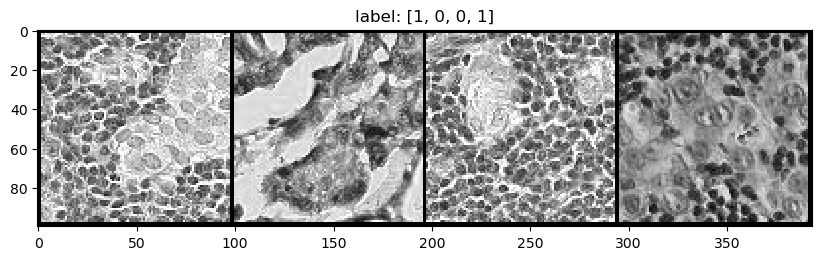

In [ ]:
# 4 Display a few images and predictions:
grid_size=4
rnd_inds=np.random.randint(0,len(histo_test),grid_size)
print("image indices:",rnd_inds)

x_grid_test=[histo_test[i][0] for i in range(grid_size)]
y_grid_test=[y_test_pred[i] for i in range(grid_size)]

x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test,y_grid_test)

### **How it works**

In step 1, we loaded the CSV file and print out the head. The labels are all set to zero since we don't know the actual labels. In step 2, we created the custom test dataset. The dataset contains 57,458 images. There is no label for these images. Then, we deployed the model on the test dataset and obtained the outputs. In step 3, we also displayed a few sample images and the predicted labels.

### **See also**

You can create a **submission file** from the predictions on the test dataset using the following code block.

First, extract the prediction probabilities from the outputs. Note that we perform the exponential function on the model outputs to convert them into probability values:

In [ ]:
print(y_test_out.shape)
cancer_preds = np.exp(y_test_out[:, 1])
print(cancer_preds.shape)

# Next, convert the prediction probabilities into a DataFrame and store them as a CSV file:
path2sampleSub = "../data/histopathologic-cancer-detection/" + "sample_submission.csv"
sample_df = pd.read_csv(path2sampleSub)
ids_list = list(sample_df.id)
pred_list = [p for p in cancer_preds]
pred_dic = dict((key[:-4], value) for (key, value) in zip(histo_test.filenames, pred_list))    
pred_list_sub = [pred_dic[id_] for id_ in ids_list]
submission_df = pd.DataFrame({'id':ids_list, 'label':pred_list_sub})
if not os.path.exists("./submissions/"):
    os.makedirs("submissions/")
    print("submission folder created!")
    
path2submission="./submissions/submission.csv"
submission_df.to_csv(path2submission, header=True, index=False)
submission_df.head()

(57458, 2)
(57458,)


AttributeError: 'histoCancerDataset' object has no attribute 'filenames'

You can submit the CSV file to the Histopathologic Cancer Detection competition web page on Kaggle, which can be accessed by going to the following link: [competition histopathologic cancer detection](https://www.kaggle.com/c/histopathologic-cancer-detection/submissions)

Choose Late Submission from the menu and upload the file, as shown in the following screenshot: